In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных

In [3]:
# изменение стандартного размера графика
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [5]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
# просмотр, какие есть уникальные события
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [7]:
# создание колонки с датой и временем в другом формате
events_data['data'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,data
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [8]:
submissions_data['data'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [9]:
# проверка дат на валидность
print('Первое действие в курсе: ', events_data.data.min())
print('Последнее действие в курсе: ', events_data.data.max())

Первое действие в курсе:  2015-06-15 04:00:48
Последнее действие в курсе:  2018-05-19 23:33:31


In [10]:
# создание колонки с датой без времени 
events_data['day'] = events_data.data.dt.date
events_data.head()

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
submissions_data['day'] = submissions_data.data.dt.date

<Axes: xlabel='day'>

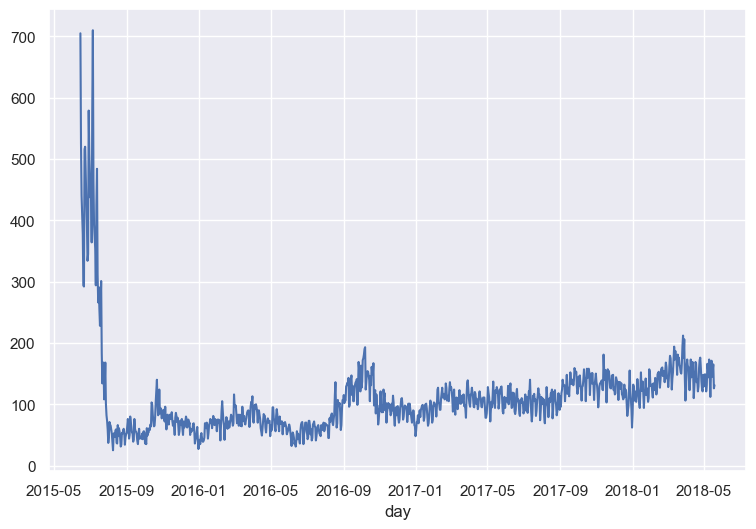

In [12]:
# график активности уникальных пользователей в день
events_data.groupby('day') \
    .user_id.nunique().plot()

<Axes: >

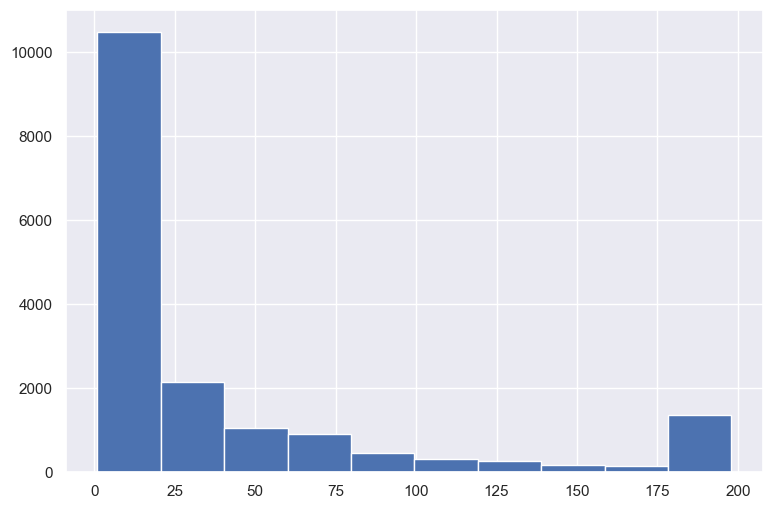

In [13]:
# отбор данных по выполненным степам
# группировка по пользователям
# подсчет количества таких выполненных степов по пользователям
# построение гистограммы
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

# но при таком подсчете теряем всех пользователей, у которых нет степов со значением 'passed',
# что дает нам неверный результат в будущем

In [14]:
missed = events_data.user_id.nunique() - events_data[events_data.action == 'passed'].user_id.nunique()
print('Потеряно при таком отборе', missed, 'пользователя')
print('Что составляет', round(missed/events_data.user_id.nunique()*100, 2), '% пользователей')

Потеряно при таком отборе 1972 пользователя
Что составляет 10.25 % пользователей


In [15]:
# правильный отбор

# reset_index - сброс составного индекса
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<Axes: >

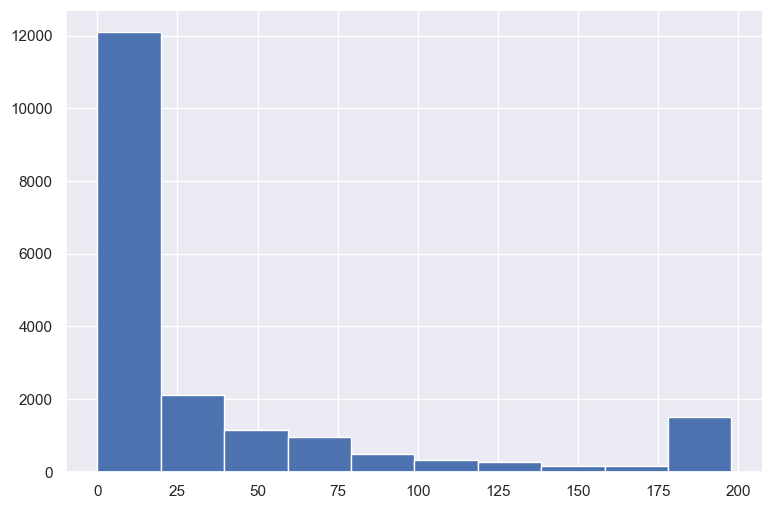

In [16]:
# построение правильной гистограммы
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index().discovered.hist()

In [17]:
user_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index()
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [18]:
# отбор данных по трем колонкам и дроп повторений по id и дням 
# (если в этот день пользователь был активен, то нам нужна только одна запись об этом)
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [19]:
# сбор в списки времени по дням, когда пользователь был активен
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [20]:
# промежутки между соседними днями, когда пользователь был на курсе
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [21]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [22]:
# сбор всех промежутков в один список и преобразование в серию (преобразование необязательно)
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

# перевод промежутков из секунд в сутки
gap_data = gap_data / (24 * 60 * 60)

<Axes: >

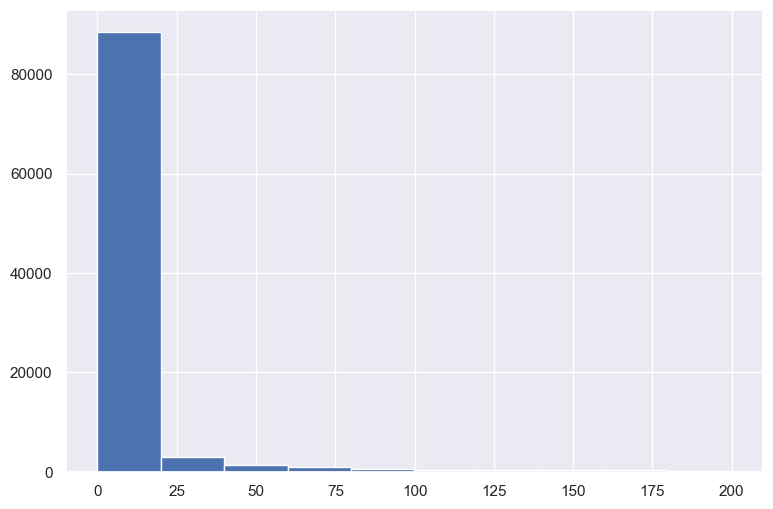

In [23]:
gap_data[gap_data < 200].hist()

In [24]:
# 90% и 95% пользователей возвращаются на курс в течение этого промежутка
print(gap_data.quantile(0.9), gap_data.quantile(0.95)) 

18.325995370370403 59.760440972222156


In [25]:
# поиск id создателя курса
# user_scores.sort_values(by='correct', ascending=False)

In [26]:
events_data.tail()

,step_id,timestamp,action,user_id,data,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [27]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [28]:
# последний timestamp на момент датасета
now = 1526772811

# 30 дней в секундах
drop_out_theshold = 30 * 24 * 60 * 60    

# отсутствовал ли пользователь на курсе более 30 дней
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_theshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [29]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [30]:
# склеивание DF в один
users_data = users_data.merge(user_scores, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [31]:
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [32]:
# действия со степами
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [33]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [34]:
# количество дней захода в курс
users_days = events_data.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [35]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [36]:
# данные не потеряны
users_data.user_id.nunique() == events_data.user_id.nunique()

True

In [37]:
users_data['passed_course'] = users_data.passed > 170
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [38]:
print('Курс прошли', round((100*1425/17809),2), '% слушателей')

Курс прошли 8.0 % слушателей


In [39]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [40]:
events_data.head()

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [41]:
# когда пользователь впервые совершил действие на курсе
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1) 

user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [42]:
# добавление колонки к другим данным
users_data = users_data.merge(user_min_time, how='outer')
users_data.head(2)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364


In [43]:
events_data.head()

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [44]:
# отбор действий пользователей в первые 3 дня после начала ими курса
events_data_train = (events_data.groupby('user_id',as_index=False).
                     apply(lambda x: x[x.timestamp < x.timestamp.min() + 259200]).
                     reset_index(drop=True))
events_data_train.head()

,step_id,timestamp,action,user_id,data,day
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27


In [45]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [46]:
#Добавляем в submissions_data время первого степа
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='left')
# Время от первого степа до последнего
submissions_data['users_time'] = submissions_data['timestamp'] - submissions_data['min_timestamp']
#Выбираем степы первых трёх дней
submissions_data_train = submissions_data[submissions_data.users_time <= 3*24*60*60]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [59]:
# сколько у пользователя уникальных дней
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns = {'day': 'days'})
X.head(2)

,user_id,days
0,2,1
1,3,1


In [60]:
# на скольких степах побывал
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns = {'step_id': 'steps_tried'})
steps_tried.head(2)

,user_id,steps_tried
0,2,2
1,3,4


In [61]:
# объединение 
X = X.merge(steps_tried, on='user_id', how='outer')
X.head(2)

,user_id,days,steps_tried
0,2,1,2
1,3,1,4


In [62]:
# добавление к данным информацию о попытках в стэпах
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index())

X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [63]:
X['correct_ratio'] = X.correct / (X.wrong+X.correct)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [64]:
X = X.merge(events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index()[['user_id', 'viewed']], how = 'outer')

In [65]:
X = X.fillna(0)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,10
1,3,1.0,4.0,4.0,4.0,0.50,192
2,8,1.0,11.0,9.0,21.0,0.30,156
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,651


In [66]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,10,False,True
1,3,1.0,4.0,4.0,4.0,0.50,192,False,True
2,8,1.0,11.0,9.0,21.0,0.30,156,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True


In [67]:
# человек либо прошел курс, либо не прошел, но уже бросил
X = X[X.is_gone_user | X.passed_course]
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,10,False,True
1,3,1.0,4.0,4.0,4.0,0.50,192,False,True
2,8,1.0,11.0,9.0,21.0,0.30,156,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True


In [68]:
y = X.passed_course.map(int)

In [69]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X.head(2)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.0,10
3,1.0,4.0,4.0,4.0,0.5,192


# Обучение модели

In [70]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [72]:
clf = tree.DecisionTreeClassifier()
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [73]:
grid_search_cv_clf.fit(X_train, y_train)
best_clf = grid_search_cv_clf.best_estimator_

In [74]:
from sklearn.metrics import precision_score, recall_score
y_pred = best_clf.predict(X_test)

In [75]:
precision_score(y_test, y_pred)

0.6804635761589404

In [76]:
recall_score(y_test, y_pred)

0.9092920353982301

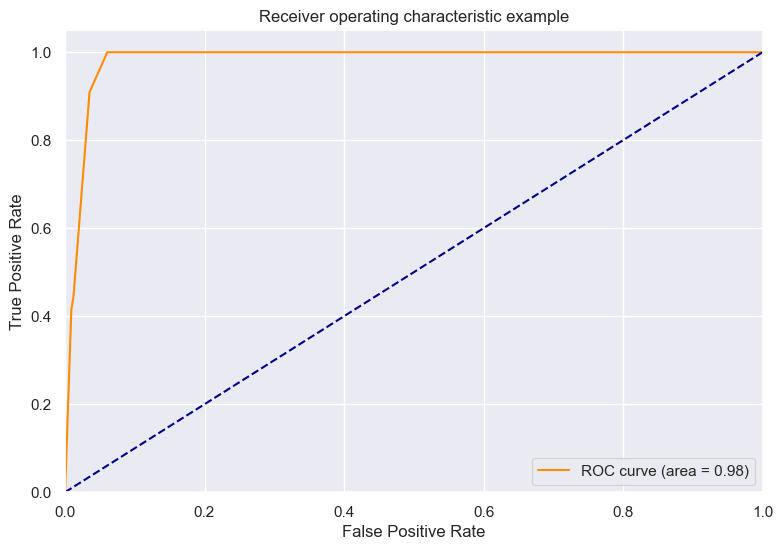

In [78]:
y_predicted_prob = best_clf.predict_proba(X_test)
# ROC кривая 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
/